In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=False)

from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

## Simulated Collidor Data

From Chapter 4: 

The simulated training data contain five thousand examples. Each line contains information about a collision event, in which a varying number of particles are produced. For each particle produced in the event, we know its type (electron (e-), positron (e+), photon (g), a so-called jet (j), a so- called b-jet (b), or a muon (m+/m-), with positive or negative charge). We also know its 4-vector, i.e. the energy, transverse component of the momentum and the theta (given here in units of pseudorapidity) and phi angles. The latter quantities are related to the separation of the emitted particle from the axis of the collision, which is important
for the selection of clean events. Finally, conservation of energy requires that we account for missing energy - in other words, energy that was carried out by undetected particles, for example neutrinos. This information is encoded in the "MET" and "METphi" variables (missing energy=MET), which list the magnitude and the azimuthal angle of the missing transverse energy vector of the event, respectively.

Overall, the format of the information for each event is the following:

MET; METphi; obj1, E1, pt1, eta1, phi1; obj2, E2, pt2, eta2, phi2; . . .

where "obj" specifies the type for each particle detected in the event.


## Data Preparation

This is to show the manipulation done to get the data in the format we need and select a random sample to keep things more manageable.

I have kept this in to illustrate that data rarely shows up neat and ready for your Machine Learning. 

Once you run through all the columns, you'll get the feature and labels file that we can work with (or you can start right away with the downloaded version).

In [54]:
# read in data
df = pd.read_csv('TrainingValidationData.csv', delimiter=',', names=list(['P'+str(i) for i in range(53)]) )
print(df.columns)

Index(['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10',
       'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30',
       'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40',
       'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50',
       'P51', 'P52'],
      dtype='object')


In [55]:
# inspect raw data
df.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52
0,0;ttbar;0.00167779;17742.1;-2.37367;j,193103.0,143393.0,0.803969,-0.198431;j,778814.0,104707.0,2.695040,-3.03908;j,125976.0,85268.9,-0.934506,3.1025;b,69106.5,55957.8,-0.661401,0.937923;j,50482.4,39522.4,0.687292,0.839734;j,82162.7,37182.8,1.426130,-0.0749548;j,638681.0,24114.8,-3.96928,3.13769;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1;ttbar;0.00167779;15567.8;-2.90015;b,183399.0,105032.0,1.153790,-2.43549;j,166852.0,93020.5,1.186420,0.203206;j,49938.5,48836.5,0.136584,0.00672176;j,168744.0,23995.2,-2.637880,2.31197;e+,32046.3,27560.8,0.563054,1.71034;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2;ttbar;0.0334195;30647.2;2.74336;j,420301.0,135727.0,-1.792050,-0.609116;j,294268.0,78516.8,-1.994660,-2.51345;b,194433.0,67511.8,-1.716620,0.314709;j,78721.8,50067.6,1.014570,1.72546;j,60548.4,50035.6,0.620308,2.79499;b,41859.8,39719.8,-0.279838,-3.04737;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3;4top;1.93132e-07;27699.6;0.617912;j,300154.0,277869.0,-0.370231,-0.684062;j,261232.0,206121.0,0.698378,1.81692;j,258771.0,166742.0,-1.006300,-1.8801;j,145917.0,142031.0,0.159003,2.47523;j,67064.7,46427.1,-0.888082,2.22281;j,328441.0,43982.4,2.698900,0.0610803;j,62307.4,28564.1,1.39952,-2.892;m+,65374.6,53015.1,-0.670218,0.241486;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4;ttbar;0.00167779;92205.9;1.57425;j,140760.0,75721.7,-1.225510,-2.92616;j,1650250.0,68573.0,-3.873460,-0.941662;j,199485.0,39008.3,-2.314910,-2.15216;j,36111.1,32994.1,-0.399817,1.25275;j,133019.0,29239.5,-2.194640,-0.13927;m-,31258.4,27580.9,-0.510817,2.75758;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# split the first column into columns we need.

new = df['P0'].str.split(';',expand=True)

new.columns = ['numID', 'processID', 'weight', 'MET', 'METphi', 'Type_1']

In [57]:
# inspect new columns
new.head()

,numID,processID,weight,MET,METphi,Type_1
0,0,ttbar,0.00167779,17742.1,-2.37367,j
1,1,ttbar,0.00167779,15567.8,-2.90015,b
2,2,ttbar,0.0334195,30647.2,2.74336,j
3,3,4top,1.93132e-07,27699.6,0.617912,j
4,4,ttbar,0.00167779,92205.9,1.57425,j


In [58]:
# join original table and these new columns
df = df.join(new, how='outer') #join them side to side

In [59]:
# inspect again
df.head()

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52,numID,processID,weight,MET,METphi,Type_1
0,0;ttbar;0.00167779;17742.1;-2.37367;j,193103.0,143393.0,0.803969,-0.198431;j,778814.0,104707.0,2.695040,-3.03908;j,125976.0,85268.9,-0.934506,3.1025;b,69106.5,55957.8,-0.661401,0.937923;j,50482.4,39522.4,0.687292,0.839734;j,82162.7,37182.8,1.426130,-0.0749548;j,638681.0,24114.8,-3.96928,3.13769;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,ttbar,0.00167779,17742.1,-2.37367,j
1,1;ttbar;0.00167779;15567.8;-2.90015;b,183399.0,105032.0,1.153790,-2.43549;j,166852.0,93020.5,1.186420,0.203206;j,49938.5,48836.5,0.136584,0.00672176;j,168744.0,23995.2,-2.637880,2.31197;e+,32046.3,27560.8,0.563054,1.71034;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,ttbar,0.00167779,15567.8,-2.90015,b
2,2;ttbar;0.0334195;30647.2;2.74336;j,420301.0,135727.0,-1.792050,-0.609116;j,294268.0,78516.8,-1.994660,-2.51345;b,194433.0,67511.8,-1.716620,0.314709;j,78721.8,50067.6,1.014570,1.72546;j,60548.4,50035.6,0.620308,2.79499;b,41859.8,39719.8,-0.279838,-3.04737;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,ttbar,0.0334195,30647.2,2.74336,j
3,3;4top;1.93132e-07;27699.6;0.617912;j,300154.0,277869.0,-0.370231,-0.684062;j,261232.0,206121.0,0.698378,1.81692;j,258771.0,166742.0,-1.006300,-1.8801;j,145917.0,142031.0,0.159003,2.47523;j,67064.7,46427.1,-0.888082,2.22281;j,328441.0,43982.4,2.698900,0.0610803;j,62307.4,28564.1,1.39952,-2.892;m+,65374.6,53015.1,-0.670218,0.241486;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,4top,1.93132e-07,27699.6,0.617912,j
4,4;ttbar;0.00167779;92205.9;1.57425;j,140760.0,75721.7,-1.225510,-2.92616;j,1650250.0,68573.0,-3.873460,-0.941662;j,199485.0,39008.3,-2.314910,-2.15216;j,36111.1,32994.1,-0.399817,1.25275;j,133019.0,29239.5,-2.194640,-0.13927;m-,31258.4,27580.9,-0.510817,2.75758;,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,ttbar,0.00167779,92205.9,1.57425,j


### The new columns have been appended at the end; we still need to split the type of product.

These can be seen separated by a ';' in some of the columns (every 4th column). Go through the columns and separate thse out.

In [60]:

for i in range(4,53,4):

    new = df['P'+str(i)].str.split(';',expand=True) 
    
    df['P'+str(i)] = new[0]
    
    df['Type_'+str(int(i/4+1))] = new[1]
    
print(df.columns)

Index(['P0', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10',
       'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29', 'P30',
       'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40',
       'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50',
       'P51', 'P52', 'numID', 'processID', 'weight', 'MET', 'METphi', 'Type_1',
       'Type_2', 'Type_3', 'Type_4', 'Type_5', 'Type_6', 'Type_7', 'Type_8',
       'Type_9', 'Type_10', 'Type_11', 'Type_12', 'Type_13', 'Type_14'],
      dtype='object')


In [61]:
# removing that first column. Redundant
df = df.drop('P0', axis=1)

In [62]:
# what kind of columns does our data contain now?
df.columns.values

array(['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12', 'P13', 'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P24', 'P25', 'P26', 'P27', 'P28', 'P29',
       'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38',
       'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47',
       'P48', 'P49', 'P50', 'P51', 'P52', 'numID', 'processID', 'weight',
       'MET', 'METphi', 'Type_1', 'Type_2', 'Type_3', 'Type_4', 'Type_5',
       'Type_6', 'Type_7', 'Type_8', 'Type_9', 'Type_10', 'Type_11',
       'Type_12', 'Type_13', 'Type_14'], dtype=object)

In [63]:
#just re-ordering the columns in the same order they were originally in but now each neatly in a data-column

cols = ['numID', 'processID', 'weight',
       'MET', 'METphi', 'Type_1', 'P1', 'P2', 'P3', 'P4',  'Type_2', 'P5', 'P6', 'P7', 'P8', 'Type_3', 'P9', 'P10', 'P11',
       'P12',  'Type_4', 'P13', 'P14', 'P15', 'P16', 'Type_5','P17', 'P18', 'P19', 'P20',
       'Type_6','P21', 'P22', 'P23', 'P24', 'Type_7','P25', 'P26', 'P27', 'P28', 'Type_8','P29',
       'P30', 'P31', 'P32', 'Type_9', 'P33', 'P34', 'P35', 'P36', 'Type_10','P37', 'P38',
       'P39', 'P40', 'Type_11', 'P41', 'P42', 'P43', 'P44', 'Type_12', 'P45', 'P46', 'P47',
       'P48', 'Type_13','P49', 'P50', 'P51', 'P52']

In [64]:
X = df[cols].drop(['numID', 'processID', 'weight'], axis = 1)

In [65]:
len(cols)

70

In [66]:
X.head() 

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
0,17742.1,-2.37367,j,193103.0,143393.0,0.803969,-0.198431,j,778814.0,104707.0,2.695040,-3.03908,j,125976.0,85268.9,-0.934506,3.1025,b,69106.5,55957.8,-0.661401,0.937923,j,50482.4,39522.4,0.687292,0.839734,j,82162.7,37182.8,1.426130,-0.0749548,j,638681.0,24114.8,-3.96928,3.13769,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15567.8,-2.90015,b,183399.0,105032.0,1.153790,-2.43549,j,166852.0,93020.5,1.186420,0.203206,j,49938.5,48836.5,0.136584,0.00672176,j,168744.0,23995.2,-2.637880,2.31197,e+,32046.3,27560.8,0.563054,1.71034,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,30647.2,2.74336,j,420301.0,135727.0,-1.792050,-0.609116,j,294268.0,78516.8,-1.994660,-2.51345,b,194433.0,67511.8,-1.716620,0.314709,j,78721.8,50067.6,1.014570,1.72546,j,60548.4,50035.6,0.620308,2.79499,b,41859.8,39719.8,-0.279838,-3.04737,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27699.6,0.617912,j,300154.0,277869.0,-0.370231,-0.684062,j,261232.0,206121.0,0.698378,1.81692,j,258771.0,166742.0,-1.006300,-1.8801,j,145917.0,142031.0,0.159003,2.47523,j,67064.7,46427.1,-0.888082,2.22281,j,328441.0,43982.4,2.698900,0.0610803,j,62307.4,28564.1,1.39952,-2.892,m+,65374.6,53015.1,-0.670218,0.241486,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92205.9,1.57425,j,140760.0,75721.7,-1.225510,-2.92616,j,1650250.0,68573.0,-3.873460,-0.941662,j,199485.0,39008.3,-2.314910,-2.15216,j,36111.1,32994.1,-0.399817,1.25275,j,133019.0,29239.5,-2.194640,-0.13927,m-,31258.4,27580.9,-0.510817,2.75758,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
X.describe() #remember that this only affects numerical columns

,P1,P2,P3,P5,P6,P7,P9,P10,P11,P13,P14,P15,P17,P18,P19,P21,P22,P23,P25,P26,P27,P29,P30,P31,P33,P34,P35,P37,P38,P39,P41,P42,P43,P45,P46,P47,P49,P50,P51
count,9.999700e+04,9.999700e+04,99997.000000,9.992600e+04,9.992600e+04,99926.000000,9.899100e+04,98991.000000,98991.000000,9.385300e+04,93853.000000,93853.000000,7.991000e+04,79910.000000,79910.000000,5.853900e+04,58539.000000,58539.000000,3.834700e+04,38347.000000,38347.000000,2.412200e+04,24122.000000,24122.000000,1.513400e+04,15134.000000,15134.000000,9.011000e+03,9011.000000,9011.000000,4.853000e+03,4853.000000,4853.000000,2.361000e+03,2361.000000,2361.000000,9.670000e+02,967.000000,967.000000
mean,3.277655e+05,1.545569e+05,-0.003555,2.502158e+05,1.077661e+05,0.002952,2.060598e+05,74817.281537,-0.002819,1.824161e+05,57910.555406,-0.002839,1.721824e+05,48861.000075,-0.004951,1.684729e+05,44167.725923,-0.002462,1.664557e+05,41661.123342,-0.000830,1.651800e+05,40757.138956,0.003005,1.654103e+05,40760.175268,0.000550,1.615391e+05,40610.894030,0.013680,1.570275e+05,38895.164290,-0.025059,1.603781e+05,38429.168022,-0.035858,1.616734e+05,38770.992037,-0.040558
std,2.992857e+05,1.123455e+05,1.350584,2.563849e+05,7.614375e+04,1.422386,2.472275e+05,44171.199946,1.542322,2.388193e+05,31288.049544,1.640667,2.406316e+05,25329.276228,1.721809,2.368950e+05,22788.335816,1.788698,2.337867e+05,22879.841904,1.834066,2.340694e+05,25917.855025,1.852271,2.272069e+05,30147.319141,1.878538,2.197876e+05,34899.356724,1.881599,2.123164e+05,31830.501192,1.894229,2.151410e+05,32762.774784,1.932522,2.074495e+05,34184.668553,1.967807
min,2.089250e+04,1.838530e+04,-4.856300,1.087540e+04,1.007280e+04,-4.788360,1.027220e+04,10023.400000,-4.892440,1.001200e+04,10004.200000,-4.897010,1.034400e+04,10006.000000,-4.893080,1.028280e+04,10006.500000,-4.930230,1.013400e+04,10009.700000,-4.920570,1.048510e+04,10060.300000,-4.921770,1.022420e+04,10009.300000,-4.884880,1.047610e+04,10046.100000,-4.814330,1.116940e+04,10047.300000,-4.841310,1.068020e+04,10024.700000,-4.802890,1.163680e+04,10051.900000,-4.641500
25%,1.371900e+05,8.806960e+04,-0.987878,9.961972e+04,6.373630e+04,-1.009580,7.534165e+04,47026.900000,-1.078880,6.102030e+04,36720.200000,-1.143060,5.329685e+04,31383.600000,-1.198820,4.980905e+04,28825.100000,-1.250715,4.830010e+04,27846.900000,-1.281040,4.725083e+04,27306.075000,-1.306000,4.541188e+04,26804.550000,-1.324485,4.401945e+04,26325.600000,-1.308170,4.249970e+04,25749.300000,-1.405300,4.176920e+04,25207.400000,-1.449130,4.220260e+04,25020.900000,-1.479920
50%,2.262300e+05,1.196960e+05,-0.003297,1.640690e+05,8.635380e+04,-0.002509,1.250130e+05,63189.700000,-0.006581,1.025380e+05,49475.900000,-0.006059,9.069685e+04,41449.600000,-0.006588,8.574750e+04,37348.500000,-0.001917,8.353000e+04,35312.000000,-0.008763,8.144470e+04,34131.000000,-0.003657,8.182995e+04,32771.700000,-0.010745,7.986780e+04,31232.700000,-0.008984,7.873760e+04,29879.400000,-0.044943,8.083190e+04,28659.200000,-0.056851,8.570070e+04,27715.200000,-0.105207
75%,4.073950e+05,1.774540e+05,0.987178,2.999222e+05,1.248410e+05,1.014055,2.319710e+05,89264.600000,1.078430,1.976550e+05,69872.000000,1.136430,1.799680e+05,58829.725000,1.189717,1.767390e+05,52490.200000,1.254020,1.772160e+05,48534.650000,1.301125,1.750300e+05,45545.350000,1.320450,1.822572e+05,42861.950000,1.336268,1.825300e+05,40546.250000,1.354115,1.738650e+05,37468.000000,1.328520,1.805500e+05,36375.500000,1.373420,1.844370e+05,34013.050000,1.425335
max,3.783780e+06,1.768980e+06,4.796060,4.379710e+06,1.687820e+06,4.810550,3.823240e+06,788338.000000,4.844930,4.126560e+06,481884.000000,4.887670,3.835360e+06,499118.000000,4.900040,3.833440e+06,504952.000000,4.943350,3.093440e+06,545365.000000,4.879880,3.167930e+06,860415.000000,4.866710,2.590720e+06,679264.000000,4.873490,2.296100e+06,732108.000000,4.845880,2.430440e+06,559006.000000,4.790720,1.888880e+06,384298.000000,4.849800,1.892590e+06,302147.000000,4.662020


Some columns that should be numerical are of type "object"

In [68]:
X.columns[X.dtypes == object]

Index(['MET', 'METphi', 'Type_1', 'P4', 'Type_2', 'P8', 'Type_3', 'P12',
       'Type_4', 'P16', 'Type_5', 'P20', 'Type_6', 'P24', 'Type_7', 'P28',
       'Type_8', 'P32', 'Type_9', 'P36', 'Type_10', 'P40', 'Type_11', 'P44',
       'Type_12', 'P48', 'Type_13', 'P52'],
      dtype='object')

Re-cast data type where appropriate, these columns are supposed to be numerical, not 'object'. 

In [69]:
for el in ['MET', 'METphi', 'P4', 'P8', 'P12',
        'P16',  'P20', 'P24',  'P28',
    'P32', 'P36', 'P40', 'P44',
      'P48', 'P52']:
    X[el] = X[el].astype('float64')

In [70]:
# checking that every column is correctly in 'object' and 'float' types
X.dtypes

MET        float64
METphi     float64
Type_1      object
P1         float64
P2         float64
P3         float64
P4         float64
Type_2      object
P5         float64
P6         float64
P7         float64
P8         float64
Type_3      object
P9         float64
P10        float64
P11        float64
P12        float64
Type_4      object
P13        float64
P14        float64
P15        float64
P16        float64
Type_5      object
P17        float64
P18        float64
P19        float64
P20        float64
Type_6      object
P21        float64
P22        float64
P23        float64
P24        float64
Type_7      object
P25        float64
P26        float64
P27        float64
P28        float64
Type_8      object
P29        float64
P30        float64
P31        float64
P32        float64
Type_9      object
P33        float64
P34        float64
P35        float64
P36        float64
Type_10     object
P37        float64
P38        float64
P39        float64
P40        float64
Type_11     

### Select 5000 rows

In [71]:
np.random.seed(10)

sel = np.random.choice(df.shape[0], 5000)

features = X.iloc[sel,:]

In [72]:
features.shape

(5000, 67)

In [73]:
features.columns

Index(['MET', 'METphi', 'Type_1', 'P1', 'P2', 'P3', 'P4', 'Type_2', 'P5', 'P6',
       'P7', 'P8', 'Type_3', 'P9', 'P10', 'P11', 'P12', 'Type_4', 'P13', 'P14',
       'P15', 'P16', 'Type_5', 'P17', 'P18', 'P19', 'P20', 'Type_6', 'P21',
       'P22', 'P23', 'P24', 'Type_7', 'P25', 'P26', 'P27', 'P28', 'Type_8',
       'P29', 'P30', 'P31', 'P32', 'Type_9', 'P33', 'P34', 'P35', 'P36',
       'Type_10', 'P37', 'P38', 'P39', 'P40', 'Type_11', 'P41', 'P42', 'P43',
       'P44', 'Type_12', 'P45', 'P46', 'P47', 'P48', 'Type_13', 'P49', 'P50',
       'P51', 'P52'],
      dtype='object')

Reset index

In [74]:
features.reset_index(drop=True, inplace=True)

In [75]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Export feature data frame to file



In [76]:
features.to_csv('ParticleID_features.csv', index_label= 'ID')

#### Select labels

In [77]:
y = df.processID[sel].values # values makes it an array

In [78]:
y

array(['ttbar', 'ttbar', 'ttbar', ..., 'ttbar', '4top', 'ttbar'],
      dtype=object)

#### Export labels to file

In [79]:
np.savetxt('ParticleID_labels.txt', y, fmt = '%s')

## Start here!

Read in features and labels.

In [191]:
features = pd.read_csv('ParticleID_features.csv', index_col='ID')

In [192]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
features.shape

(5000, 67)

In [194]:
y = np.genfromtxt('ParticleID_labels.txt', dtype = str)

In [195]:
y

array(['ttbar', 'ttbar', 'ttbar', ..., 'ttbar', '4top', 'ttbar'],
      dtype='<U5')

### We need to turn categorical (string-type) labels into an array, e.g. 0/1.

In [196]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder() #turns categorical into 1 ... N

In [197]:
y

array(['ttbar', 'ttbar', 'ttbar', ..., 'ttbar', '4top', 'ttbar'],
      dtype='<U5')

In [198]:
y = le.fit_transform(y)

In [199]:
y #This uses 1 for the first instance, I actually wanted  4top to be my positive label.

array([1, 1, 1, ..., 1, 0, 1])

In [200]:
target = np.abs(y - 1)

In [201]:
target # Happier now.

array([0, 0, 0, ..., 0, 1, 0])

#### Let's take a look at these features, using the "describe" property.

In [202]:
features.describe() #Note that this automatically excludes non-numerical type columns

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,P38,P39,P40,P41,P42,P43,P44,P45,P46,P47,P48,P49,P50,P51,P52
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4.950000e+03,4950.000000,4950.000000,4950.000000,4.717000e+03,4717.000000,4717.000000,4717.000000,4.002000e+03,4002.000000,4002.000000,4002.000000,2.871000e+03,2871.00000,2871.000000,2871.000000,1.889000e+03,1889.000000,1889.000000,1889.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,7.290000e+02,729.000000,729.000000,729.000000,4.420000e+02,442.000000,442.000000,442.000000,2.610000e+02,261.000000,261.000000,261.000000,1.270000e+02,127.000000,127.000000,127.000000,5.600000e+01,56.000000,56.000000,56.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.527799e+05,1.080302e+05,-0.029936,0.007327,2.117980e+05,74863.343131,-0.025104,0.011845,1.805997e+05,57289.049481,0.010723,0.045266,1.780366e+05,48798.018516,0.015167,-0.031312,1.705620e+05,44042.67015,-0.022948,0.014522,1.628825e+05,41151.069666,0.002228,0.006738,1.581409e+05,40250.387015,0.072349,-0.035907,1.596814e+05,40139.289849,0.061654,-0.045868,1.574039e+05,39703.038235,0.118543,0.024249,1.561160e+05,38173.716092,0.029455,0.026422,1.631051e+05,34876.849606,0.206978,-0.001085,1.456600e+05,36151.183929,-0.000879,0.219260
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638580e+05,8.136261e+04,1.439105,1.828832,2.510361e+05,46309.512365,1.577316,1.802715,2.383403e+05,32013.857623,1.634072,1.812078,2.577958e+05,26252.978520,1.744489,1.784248,2.381745e+05,23510.65367,1.806611,1.811101,2.269341e+05,20988.953157,1.815312,1.771888,2.118782e+05,26556.025657,1.836492,1.796932,2.308620e+05,30074.756789,1.842798,1.788596,2.165489e+05,30502.312276,1.872084,1.826435,2.319016e+05,29324.658352,1.884750,1.753017,2.248603e+05,20433.767238,1.998859,1.949004,1.943657e+05,25861.883410,1.941707,1.910400
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,1.087540e+04,1.080000e+04,-4.668790,-3.140530,1.221050e+04,10639.800000,-4.520250,-3.141480,1.169190e+04,10818.000000,-4.616550,-3.136130,1.110310e+04,10287.000000,-4.778980,-3.139040,1.070330e+04,10066.90000,-4.930230,-3.140380,1.197700e+04,11260.200000,-4.758150,-3.135630,1.380860e+04,10973.300000,-4.606330,-3.132610,1.119760e+04,10067.900000,-4.814380,-3.136380,1.615530e+04,10183.700000,-4.803880,-3.135910,2.004750e+04,14800.200000,-4.400470,-3.130690,1.780380e+04,12987.900000,-4.447660,-3.139820,2.512510e+04,14836.000000,-4.448760,-2.990730
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007510e+05,6.321840e+04,-1.060500,-1.602460,7.636905e+04,46549.475000,-1.125620,-1.547417,5.999090e+04,36097.700000,-1.121240,-1.518030,5.278370e+04,30891.650000,-1.198468,-1.550615,5.007050e+04,28453.95000,-1.250050,-1.586675,4.695560e+04,27963.500000,-1.231420,-1.475380,4.535515e+04,27140.550000,-1.243963,-1.626687,4.387110e+04,26825.000000,-1.226980,-1.513330,4.410735e+04,26589.250000,-1.223240,-1.422415,4.092160e+04,25298.300000,-1.413650,-1.270700,4.365005e+04,24742.500000,-1.259230,-1.817600,4.112588e+04,24974.125000,-1.243362,-1.490900
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.659740e+05,8.584360e+04,-0.057428,0.015111,1.288565e+05,62498.400000,-0.040648,0.034238,9.922610e+04,48949.200000,-0.035512,0.060279,9.206885e+04,41054.850000,0.054393,-0.079641,8.593460e+04,37378.30000,-0.046667,0.040528,7.975460e+04,34681.700000,0.025305,0.046141,8.315485e+04,33683.550000,0.156083,-0.015617,7.894980e+04,33328.000000,0.072709,-0.052590,7.609735e+04,30942.700000,0.035675,0.090282,7.568430e+04,29479.700000,-0.088908,-0.041002,8.050910e+04,28262.800000,0.120301,-0.232455,9.553645e+04,27353.550000,-0.121213,0.128103
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.9999

### Important:

Looking at the "count" row, we can see that the whole data set has 5,000 rows, but some columns are present only for a fraction of them. This is because of the variable number of products in each collision.

#### Option 1: Only consider first 16 columns (first four products) so we have limited imputing/manipulation problems.

In [203]:
features_lim = features[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16']]

In [204]:
features_lim.head()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
ID,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,137571.0,128444.0,-0.345744,-0.307112,174209.0,127932.0,0.826569,2.332000,86788.9,84554.9,-0.180795,2.187970,140289.0,76955.8,-1.19933,-1.302800
1,57594.2,-0.509253,161529.0,80458.3,-1.318010,1.402050,291490.0,68462.9,-2.126740,-2.582310,44270.1,35139.6,-0.706120,-0.371392,72883.9,26902.2,-1.65386,-3.129630
2,82313.3,1.686840,167130.0,113078.0,0.937258,-2.068680,102423.0,54922.3,1.226850,0.646589,60768.9,36244.3,1.102890,-1.434480,77714.0,27801.5,1.68461,1.389690
3,30610.8,2.617120,112267.0,61383.9,-1.211050,-1.457800,40647.8,39472.0,-0.024646,-2.222800,201589.0,32978.6,-2.496040,1.137810,90096.7,26964.5,1.87132,0.817631
4,45153.1,-2.241350,178174.0,100164.0,1.166880,-0.018721,92351.3,69762.1,0.774114,2.568740,61625.2,50086.7,0.652572,-3.012800,104193.0,31151.0,1.87641,0.865381


In [205]:
features_lim.describe() #This automatically excludes non-numerical type columns, and missing values/NaNs are not counted.

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,4.997000e+03,4.997000e+03,4997.000000,4997.000000,4.950000e+03,4950.000000,4950.000000,4950.000000,4.717000e+03,4717.000000,4717.000000,4717.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.527799e+05,1.080302e+05,-0.029936,0.007327,2.117980e+05,74863.343131,-0.025104,0.011845,1.805997e+05,57289.049481,0.010723,0.045266
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638580e+05,8.136261e+04,1.439105,1.828832,2.510361e+05,46309.512365,1.577316,1.802715,2.383403e+05,32013.857623,1.634072,1.812078
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,1.087540e+04,1.080000e+04,-4.668790,-3.140530,1.221050e+04,10639.800000,-4.520250,-3.141480,1.169190e+04,10818.000000,-4.616550,-3.136130
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007510e+05,6.321840e+04,-1.060500,-1.602460,7.636905e+04,46549.475000,-1.125620,-1.547417,5.999090e+04,36097.700000,-1.121240,-1.518030
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.659740e+05,8.584360e+04,-0.057428,0.015111,1.288565e+05,62498.400000,-0.040648,0.034238,9.922610e+04,48949.200000,-0.035512,0.060279
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.999950e+05,1.238700e+05,1.028340,1.605210,2.421225e+05,89587.500000,1.066302,1.570887,1.914340e+05,68782.100000,1.159480,1.612220
max,692674.000000,3.141130,3.186360e+06,1.276710e+06,4.141410,3.138540,3.587700e+06,1.146330e+06,4.559150,3.139200,2.800410e+06,788338.000000,4.798090,3.139020,2.503590e+06,481884.000000,4.730480,3.139660


There are still some feature columns with different length! This means there might be NaN values. Let's replace them with 0 for the moment. 

In [206]:
#Take a look for column P10

np.where(np.isnan(features_lim.P10))

(array([ 103,  219,  236,  558,  672,  730,  760,  889,  907,  982, 1169,
        1211, 1276, 1295, 1309, 1431, 1459, 1687, 1758, 1824, 1960, 2078,
        2165, 2286, 2321, 2335, 2681, 2724, 2784, 2801, 2872, 2888, 3079,
        3171, 3257, 3289, 3321, 3566, 3599, 3671, 3716, 3786, 3838, 3940,
        4141, 4539, 4540, 4795, 4818, 4912]),)

In [207]:
features_lim = features_lim.fillna(0) #Fill with 0 everywhere there is a NaN

#### Let's see what "describe" says now.

In [208]:
features_lim.describe()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16
count,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,64071.074332,-0.028916,3.301357e+05,1.540486e+05,-0.039812,-0.003049,2.526283e+05,1.079653e+05,-0.029918,0.007323,2.096800e+05,74114.709700,-0.024853,0.011727,1.703778e+05,54046.489280,0.010116,0.042704
std,60525.122480,1.819257,3.068202e+05,1.149469e+05,1.361762,1.814855,2.638514e+05,8.138121e+04,1.438673,1.828283,2.506651e+05,46675.655162,1.569410,1.793678,2.352279e+05,33795.723384,1.587146,1.760070
min,290.756000,-3.141010,3.857940e+04,2.825400e+04,-4.110220,-3.140710,0.000000e+00,0.000000e+00,-4.668790,-3.140530,0.000000e+00,0.000000,-4.520250,-3.141480,0.000000e+00,0.000000,-4.616550,-3.136130
25%,24352.375000,-1.619905,1.369522e+05,8.883690e+04,-1.035570,-1.574213,1.007050e+05,6.320942e+04,-1.059270,-1.599617,7.488228e+04,46165.375000,-1.108390,-1.532477,5.480870e+04,33959.400000,-1.050477,-1.424080
50%,46814.400000,-0.055612,2.263525e+05,1.182015e+05,-0.038731,-0.009037,1.658985e+05,8.581595e+04,-0.056810,0.012737,1.277135e+05,62167.100000,-0.023321,0.006687,9.259335e+04,47278.800000,0.000000,0.000000
75%,83032.350000,1.537323,4.077158e+05,1.771265e+05,0.943598,1.542370,2.999058e+05,1.238520e+05,1.028055,1.601880,2.406498e+05,89065.300000,1.048617,1.553310,1.831228e+05,66846.300000,1.085627,1.521765
max,692674.000000,3.141130,3.186360e+06,1.276710e+06,4.141410,3.138540,3.587700e+06,1.146330e+06,4.559150,3.139200,2.800410e+06,788338.000000,4.798090,3.139020,2.503590e+06,481884.000000,4.730480,3.139660


Yay - we now have consistent sizes, so we can use these as feature arrays, BUT be mindful of possible negative impacts of our imputing strategies.

### Let's move onto a quick exploration of labels.

In [209]:
np.sum(target)/len(target) #distribution (helps with benchmarking!)

0.1622

84\% in the negative label, 16\% in the positive label. A bit unbalanced; a classifier that puts everything in the negative class will have 84\% accuracy.

How about a random classifier that just assigns a random value according to class distribution?

In [210]:
#Numerical solution

acc=0
for i in range(1000):
    x = np.random.choice(target,5000)
    acc += metrics.accuracy_score(target,x)
print(acc/1000)

#Analytic solution

print(0.8378*(0.8378) + 0.1622*0.1622)

0.7280914000000002
0.72821768


### Let's start with a linear model; model = SVC()

Establish benchmark: linear model, no regularization (C parameter very high)

In [211]:
bmodel = LinearSVC(dual = False, C = 1000) #Prefer dual=False when n_samples > n_features. If not, will not converge!!

In [212]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101) 

In [213]:
l_benchmark_lim = cross_validate(bmodel, features_lim, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [214]:
l_benchmark_lim

{'fit_time': array([0.06237912, 0.02444887, 0.02487493, 0.02931499, 0.02083993]),
 'score_time': array([0.01064873, 0.00262022, 0.00246286, 0.0129149 , 0.00273395]),
 'test_score': array([0.841, 0.825, 0.829, 0.83 , 0.833]),
 'train_score': array([0.8315 , 0.83275, 0.8315 , 0.83125, 0.832  ])}

In [215]:
np.round(l_benchmark_lim['test_score'].mean(),3), np.round(l_benchmark_lim['test_score'].std(), 3)

(0.832, 0.005)

We can also check the predicted labels. Cross\_val\_predict will compile labels predicted when each object was in the test fold.

In [216]:
ypred_bench_lim = cross_val_predict(bmodel, features_lim, target, cv = cv)

In [217]:
ypred_bench_lim.sum(), target.sum() #worse than a super silly classifier that says no to everything

(83, 811)

### How about with scaling?

In [218]:
from sklearn.pipeline import make_pipeline #This allows one to build different steps together

In [219]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False, C = 1000)) #changed to linear SVC

benchmark_lim_piped = cross_validate(piped_model, features_lim, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [220]:
benchmark_lim_piped

{'fit_time': array([0.07761097, 0.02033997, 0.01326275, 0.02034688, 0.01684928]),
 'score_time': array([0.00460291, 0.013484  , 0.00331211, 0.00200915, 0.00208569]),
 'test_score': array([0.894, 0.889, 0.89 , 0.892, 0.899]),
 'train_score': array([0.89575, 0.895  , 0.895  , 0.89825, 0.89275])}

In [227]:
np.round(benchmark_lim_piped['test_score'].mean(),3), np.round(benchmark_lim_piped['test_score'].std(), 3)

(0.893, 0.004)

This is a significant improvement, and the comparison between test and train scores tells us already something about the problem that we have. We can formalize this by looking at the learning curves, which tell us both about gap between train/test scores, AND whether we need more data.

### Learning curves 

Note: Import function at the end of the notebook.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

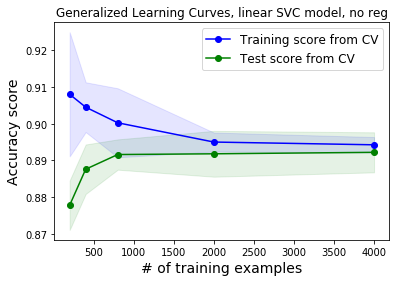

In [222]:
plot_learning_curve(piped_model, 'Generalized Learning Curves, linear SVC model, no reg', features_lim, target, train_sizes = np.array([0.05,0.1,0.2,0.5,1.0]), cv = KFold(n_splits=5, shuffle=True))
#plt.savefig('LC_SVC.png')

### Conclusions??

Our classifier is behaving better than a random/lazy one.

Our model does not suffer from high variance, so for improvement we'd look at "high bias" fixes.

Having more data would not help.

### Parameter optimization 

(note: this is NOT nested cross validation).

In [226]:
piped_model = make_pipeline(StandardScaler(), SVC()) #non linear so I can change the kernel

piped_model.get_params() #this shows how we can access parameters both for the scaler and the classifier

{'memory': None,
 'steps': [('standardscaler', StandardScaler()), ('svc', SVC())],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'svc': SVC(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

### We can define a grid of parameter values to run the optimization. 

(should do nested CV to estimate generalization error!)

Note that this might take a while (~15 mins on my laptop). 


In [224]:
#optimizing SVC: THIS IS NOT YET NESTED CV

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001,'scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 100.0, 1000], \
              'svc__degree': [2, 4, 8]}

model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_lim,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   30.2s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 600 out of 600 | elapsed: 20.7min finished


Best params, best score: 0.8950 {'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


#### Visualize the scores in a data frame, and rank them according to test scores.

I like to look at mean, std of test scores, mean of train scores (so I can evaluate if they differ and the significance of the result), and also fitting time (would pick a model that takes less time if scores are comparable).

In [228]:
scores_lim = pd.DataFrame(model.cv_results_)

scores_lim[['params','mean_test_score','std_test_score','mean_train_score', \
            'mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
45,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8950,0.002530,0.89990,0.343721
29,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8950,0.002530,0.89990,0.345388
37,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8950,0.002530,0.89990,0.353249
47,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.8936,0.006651,0.93965,0.461199
31,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.8936,0.006651,0.93965,0.417767
39,"{'svc__C': 1.0, 'svc__degree': 4, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}",0.8936,0.006651,0.93965,0.486583
53,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8936,0.004499,0.91270,0.385419
61,"{'svc__C': 10.0, 'svc__degree': 4, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8936,0.004499,0.91270,0.346677
69,"{'svc__C': 10.0, 'svc__degree': 8, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}",0.8936,0.004499,0.91270,0.376987
43,"{'svc__C': 1.0, 'svc__degree': 8, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.8932,0.005154,0.92275,0.390099


#### We can also isolate one type of kernel to look at it more closely.

In [229]:
scores_lim[scores_lim['param_svc__kernel'] == 'poly'][['params','mean_test_score','std_test_score',\
                        'mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', ascending = False)

,params,mean_test_score,std_test_score,mean_train_score,mean_fit_time
78,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8770,0.008854,0.88795,39.745749
102,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8768,0.008863,0.88805,642.679710
98,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8768,0.008863,0.88810,114.265762
74,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8766,0.008958,0.88740,12.804653
50,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8766,0.009069,0.88560,1.409941
54,"{'svc__C': 10.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8760,0.008967,0.88680,3.992400
100,"{'svc__C': 1000, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}",0.8760,0.008967,0.88680,3.201285
76,"{'svc__C': 100.0, 'svc__degree': 2, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}",0.8758,0.007250,0.88415,0.747539
30,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 0.1, 'svc__kernel': 'poly'}",0.8758,0.007250,0.88410,0.706559
26,"{'svc__C': 1.0, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.8752,0.007547,0.88180,0.433303


In [ ]:
scores_lim.columns

### Final diagnosis 

The problem here is high bias, which is not that surprising given that we are using only a subset of features.

We can try two things: making up new features which might help, based on what we know about the problem, and using an imputing strategy to include information about the discarded features.

### Define some new variables 

In [230]:
features = features.fillna(0) #takes care of nan

In [231]:
features = features.replace('', 0) #takes care of empty string values

In [232]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [ ]:
np.unique(features.Type_1.values)

Let's start by looking at what kind of particles we have as a product of the collision.

In [233]:
np.unique(np.array([features['Type_'+str(i)].values for i in range(1,14)]).astype('str'))

array(['0', 'b', 'e+', 'e-', 'g', 'j', 'm+', 'm-'], dtype='<U2')

Here are the proposed new features (justification can be found in the draft of this chapter posted on BB!)
    
    1. The total number of particles produced
    2. The total number of b jets
    3. The total number of jets
    4. The total number of leptons (electrons, positron, mu+, mu-)

In [234]:
#count number of non-zero types 

ntot = np.array([-(np.sum(np.array([features['Type_'+str(i)].values[j] == 0 for i in range(1,14)])) - 13) for j in range(features.shape[0])])

In [235]:
#define new column in my data frame

features['Total_products'] = ntot

In [236]:
#count number of b jets 

nbtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'b' for i in range(1,14)])) for j in range(features.shape[0])])

In [237]:
#define new column in my data frame

features['Total_b'] = nbtot

In [238]:
#Actually, let's count all types (jets, photons g, e-, e+, mu-, mu+)

njtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'j' for i in range(1,14)])) for j in range(features.shape[0])])

In [239]:
ngtot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'g' for i in range(1,14)])) for j in range(features.shape[0])])

In [240]:
n_el_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'e-' for i in range(1,14)])) for j in range(features.shape[0])])

In [241]:
n_pos_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'e+' for i in range(1,14)])) for j in range(features.shape[0])])

In [242]:
n_muneg_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'm-' for i in range(1,14)])) for j in range(features.shape[0])])

In [243]:
n_mupos_tot = np.array([np.sum(np.array([features['Type_'+str(i)].values[j] == 'm+' for i in range(1,14)])) for j in range(features.shape[0])])

In [244]:
n_lepton_tot = n_el_tot + n_pos_tot + n_muneg_tot + n_mupos_tot

And here we define the other new features:

In [245]:
features['Total_j'] = njtot
features['Total_g'] = ngtot
features['Total_leptons'] = n_lepton_tot

In [247]:
features.head()

,MET,METphi,Type_1,P1,P2,P3,P4,Type_2,P5,P6,P7,P8,Type_3,P9,P10,P11,P12,Type_4,P13,P14,P15,P16,Type_5,P17,P18,P19,P20,Type_6,P21,P22,P23,P24,Type_7,P25,P26,P27,P28,Type_8,P29,P30,P31,P32,Type_9,P33,P34,P35,P36,Type_10,P37,P38,P39,P40,Type_11,P41,P42,P43,P44,Type_12,P45,P46,P47,P48,Type_13,P49,P50,P51,P52,Total_products,Total_b,Total_j,Total_g,Total_leptons
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,j,137571.0,128444.0,-0.345744,-0.307112,j,174209.0,127932.0,0.826569,2.332000,b,86788.9,84554.9,-0.180795,2.187970,j,140289.0,76955.8,-1.19933,-1.302800,m+,85230.6,70102.4,-0.645689,-1.659540,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,1,3,0,1
1,57594.2,-0.509253,j,161529.0,80458.3,-1.318010,1.402050,j,291490.0,68462.9,-2.126740,-2.582310,e-,44270.1,35139.6,-0.706120,-0.371392,e+,72883.9,26902.2,-1.65386,-3.129630,0,0.0,0.0,0.000000,0.000000,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,4,0,2,0,2
2,82313.3,1.686840,b,167130.0,113078.0,0.937258,-2.068680,j,102423.0,54922.3,1.226850,0.646589,j,60768.9,36244.3,1.102890,-1.434480,j,77714.0,27801.5,1.68461,1.389690,j,26840.0,24469.3,-0.388937,-1.647260,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,1,4,0,0
3,30610.8,2.617120,j,112267.0,61383.9,-1.211050,-1.457800,b,40647.8,39472.0,-0.024646,-2.222800,j,201589.0,32978.6,-2.496040,1.137810,j,90096.7,26964.5,1.87132,0.817631,j,28235.4,25887.9,-0.411528,2.024290,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,1,4,0,0
4,45153.1,-2.241350,j,178174.0,100164.0,1.166880,-0.018721,j,92351.3,69762.1,0.774114,2.568740,j,61625.2,50086.7,0.652572,-3.012800,j,104193.0,31151.0,1.87641,0.865381,j,746585.0,26219.3,4.041820,-0.874169,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,5,0,5,0,0


### Feature engineering 1: impact of ad-hoc variables

In [248]:
features_lim_2 = features[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16','Total_products', 'Total_b' ,'Total_j','Total_g', 
              'Total_leptons']]

In [249]:
bmodel #remember our benchmark model?

LinearSVC(C=1000, dual=False)

In [250]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False, C = 1000))

In [251]:
benchmark_lim2_piped = cross_validate(piped_model, features_lim_2, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [252]:
benchmark_lim2_piped

{'fit_time': array([0.04381394, 0.05037808, 0.02831268, 0.04360008, 0.01823092]),
 'score_time': array([0.00939989, 0.00736189, 0.00367999, 0.00839591, 0.00370693]),
 'test_score': array([0.952, 0.939, 0.961, 0.948, 0.94 ]),
 'train_score': array([0.95   , 0.9555 , 0.94825, 0.95   , 0.95   ])}

In [253]:
np.round(benchmark_lim2_piped['test_score'].mean(),3), np.round(benchmark_lim2_piped['test_score'].std(), 3)

(0.948, 0.008)

In [ ]:
piped_model = make_pipeline(StandardScaler(), SVC())

In [ ]:
#optimizing SVC: Takes a while (~ 15 mins!)

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001,'scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 100.0], 'svc__degree': [2, 4, 8]}

nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_lim_2,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

In [ ]:
scores_lim_2 = pd.DataFrame(model.cv_results_)
scores_lim_2[['params','mean_test_score','mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)

### Another feature engineering attempt we could potentially do is use the type of product in the i-th location as a feature.

We could do it with label encoding, but this introduces a notion of distance metric (labels that are mapped to 0 and 1 are interpreted to be closer to each other than labels that are mapped into 0 and 7).

We introduce as many new columns as categorical labels, and we just use a 0/1 to indicate that the particle is of that type.

In [254]:
features_add = pd.get_dummies(data=features, columns=['Type_'+str(i) for i in range(1,14)])

In [255]:
features_add.columns[58:80]

Index(['Total_leptons', 'Type_1_b', 'Type_1_j', 'Type_2_0', 'Type_2_b',
       'Type_2_e+', 'Type_2_e-', 'Type_2_g', 'Type_2_j', 'Type_2_m+',
       'Type_2_m-', 'Type_3_0', 'Type_3_b', 'Type_3_e+', 'Type_3_e-',
       'Type_3_g', 'Type_3_j', 'Type_3_m+', 'Type_3_m-', 'Type_4_0',
       'Type_4_b', 'Type_4_e+'],
      dtype='object')

In [256]:
features_add.shape

(5000, 156)

### Feature engineering 2: add other variables (type of product)

In [257]:
features_lim_3 = features_add[['MET', 'METphi', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11',
       'P12',  'P13', 'P14', 'P15', 'P16','Total_products', 'Total_b' ,'Total_j','Total_g', 
              'Total_leptons','Type_1_b',
       'Type_1_j', 'Type_2_0', 'Type_2_b', 'Type_2_e+', 'Type_2_e-',
       'Type_2_g', 'Type_2_j', 'Type_2_m+', 'Type_2_m-', 'Type_3_0',
       'Type_3_b', 'Type_3_e+', 'Type_3_e-', 'Type_3_g', 'Type_3_j',
       'Type_3_m+', 'Type_3_m-', 'Type_4_0', 'Type_4_b', 'Type_4_e+',
       'Type_4_e-', 'Type_4_g', 'Type_4_j', 'Type_4_m+', 'Type_4_m-']]

In [258]:
features_lim_3.head()

,MET,METphi,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,Total_products,Total_b,Total_j,Total_g,Total_leptons,Type_1_b,Type_1_j,Type_2_0,Type_2_b,Type_2_e+,Type_2_e-,Type_2_g,Type_2_j,Type_2_m+,Type_2_m-,Type_3_0,Type_3_b,Type_3_e+,Type_3_e-,Type_3_g,Type_3_j,Type_3_m+,Type_3_m-,Type_4_0,Type_4_b,Type_4_e+,Type_4_e-,Type_4_g,Type_4_j,Type_4_m+,Type_4_m-
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62803.5,-1.810010,137571.0,128444.0,-0.345744,-0.307112,174209.0,127932.0,0.826569,2.332000,86788.9,84554.9,-0.180795,2.187970,140289.0,76955.8,-1.19933,-1.302800,5,1,3,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,57594.2,-0.509253,161529.0,80458.3,-1.318010,1.402050,291490.0,68462.9,-2.126740,-2.582310,44270.1,35139.6,-0.706120,-0.371392,72883.9,26902.2,-1.65386,-3.129630,4,0,2,0,2,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,82313.3,1.686840,167130.0,113078.0,0.937258,-2.068680,102423.0,54922.3,1.226850,0.646589,60768.9,36244.3,1.102890,-1.434480,77714.0,27801.5,1.68461,1.389690,5,1,4,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,30610.8,2.617120,112267.0,61383.9,-1.211050,-1.457800,40647.8,39472.0,-0.024646,-2.222800,201589.0,32978.6,-2.496040,1.137810,90096.7,26964.5,1.87132,0.817631,5,1,4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,45153.1,-2.241350,178174.0,100164.0,1.166880,-0.018721,92351.3,69762.1,0.774114,2.568740,61625.2,50086.7,0.652572,-3.012800,104193.0,31151.0,1.87641,0.865381,5,0,5,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [259]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False, C = 10**3))

In [260]:
benchmark = cross_validate(piped_model, features_lim_3, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [261]:
benchmark

{'fit_time': array([0.08524799, 0.09001493, 0.12118411, 0.07429624, 0.05330181]),
 'score_time': array([0.00335217, 0.00521612, 0.00332212, 0.0059309 , 0.00504398]),
 'test_score': array([0.953, 0.937, 0.959, 0.949, 0.942]),
 'train_score': array([0.95075, 0.955  , 0.947  , 0.951  , 0.952  ])}

In [262]:
np.round(benchmark['test_score'].mean(),3), np.round(benchmark['test_score'].std(), 3)

(0.948, 0.008)

In [263]:
np.round(benchmark['train_score'].mean(),3), np.round(benchmark['train_score'].std(), 3)

(0.951, 0.003)

#### No further improvement is observed, although we should optimize the model.

In [ ]:
piped_model = make_pipeline(StandardScaler(), SVC())

In [ ]:
#optimizing SVC: 

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001,'scale', 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 100.0, 1000.0], 'svc__degree': [4]} #poly never helps
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_lim_3,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

scores_lim_3 = pd.DataFrame(model.cv_results_)
scores_lim_3[['params','mean_test_score','mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)

### Finally, we can try with all the features

In [264]:
features_add.shape

(5000, 156)

In [265]:
piped_model = make_pipeline(StandardScaler(), LinearSVC(dual = False, C = 1000))

In [266]:
cv

StratifiedKFold(n_splits=5, random_state=101, shuffle=True)

In [267]:
benchmark = cross_validate(piped_model, features_add, target, cv = cv, scoring = 'accuracy', return_train_score=True)

In [268]:
benchmark

{'fit_time': array([1.14975405, 7.8028729 , 4.83948803, 0.99405408, 1.369555  ]),
 'score_time': array([0.01633787, 0.01149893, 0.06704593, 0.00920701, 0.00860786]),
 'test_score': array([0.94 , 0.93 , 0.957, 0.929, 0.929]),
 'train_score': array([0.95275, 0.957  , 0.949  , 0.95675, 0.956  ])}

In [269]:
np.round(benchmark['test_score'].mean(),3), np.round(benchmark['test_score'].std(), 3)

(0.937, 0.011)

In [270]:
np.round(benchmark['train_score'].mean(),3), np.round(benchmark['train_score'].std(), 3)

(0.954, 0.003)

### Interesting: the model with all features has higher variance.

In [ ]:
piped_model = make_pipeline(StandardScaler(), SVC())

In [ ]:
#optimizing SVC: THIS IS NOT YET NESTED CV

parameters = {'svc__kernel':['poly', 'rbf'], \
              'svc__gamma':[0.00001, 0.001, 0.01, 0.1], 'svc__C':[0.1, 1.0, 10.0, 1000.0], 'svc__degree': [4]} #poly never helps
nmodels = np.product([len(el) for el in parameters.values()])
model = GridSearchCV(piped_model, parameters, cv = StratifiedKFold(n_splits=5, shuffle=True), \
                     verbose = 2, n_jobs = 4, return_train_score=True)
model.fit(features_add,target)

print('Best params, best score:', "{:.4f}".format(model.best_score_), \
      model.best_params_)

In [ ]:
scores_all = pd.DataFrame(model.cv_results_)
scores_all[['params','mean_test_score','mean_train_score','mean_fit_time']].sort_values(by = 'mean_test_score', \
                                                    ascending = False)

## Morale of the story: feature engineering often works best if we use subject matter knowledge, and more features is not necessarily better!

In [221]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'accuracy', scale = False):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("# of training examples",fontsize = 14)
 
    plt.ylabel("Accuracy score",fontsize = 14)
    
    if (scale == True):
        scaler = sklearn.preprocessing.StandardScaler()
        X = scaler.fit_transform(X)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score from CV")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from CV")

    plt.legend(loc="best",fontsize = 12)
    return plt

### Ok, two quizzes that I was too lazy to type elsewhere.

1) Nested cross validation is used to…

<b> A. Report the correct generalization error for optimized model parameters. </b>

B. Decide between classification and regression 

C. Build more training samples

D. Turn unsupervised into supervised learning

2) You are doing nested cross validation and you have an outer loop with 5 folds and an inner loop with 3 folds. After selecting parameters in the inner CV loop, you report as generalization error…

A. The best score obtained in the 15 folds.

<b> B. The average score, where the average is calculated on the 5 test outer folds, obtained by the model optimized on the inner 3 folds. </b>

C. The average of all the scores in the 15 folds.

D. The worst score, just to be on the safe side.

